In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

# Implement the Euler-Maruyama and Milstein solvers

In [4]:
# An SDE solver

def EM(X, t, dt, a, b, dW=None):
    # Euler-Maruyama method, with drift a(X, t) and diffusion b(X, t)
    # Unless provided, generate random dW, Gaussian with mean=0 and variance=dt
    # and the correct number of elements
    if dW is None:
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=X.shape)
    # Calculate and return next value
    return X + a(X, t)*dt + b(X, t)*dW

def milstein_finite_diff(X, t, dt, a, b, dW=None):
    # The Milstein method, with drift a(X, t) and diffusion b(X, t)
    # Unless provided, generate random dW, Gaussian with mean=0 and variance=dt
    # and the correct number of elements
    if dW is None:
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=X.shape)
    # Calculate derivative of b(X, t) with respect to X,
    # using central finite difference
    delta = 1e-6
    dbdx = (b(X+delta/2, t) - b(X-delta/2, t)) / delta
    # Calculate and return next value
    return X + a(X, t)*dt + b(X, t)*dW + (1/2)*b(X, t)*dbdx*(dW**2 - dt)

def solve_SDE(X0, tmax, dt, a, b, solver, W=None):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    Nt = int(tmax/dt) + 1
    # If X0 is not an array, turn it into a 1-element array
    if not isinstance(X0, np.ndarray):
        X0 = np.array([X0])
    # Arrays to track solution
    X = np.zeros((Nt, *X0.shape))
    X[0,:] = X0
    t = 0
    for n in range(1, Nt):
        # Call solver, with pre-computed W if available
        if W is None:
            X[n,:] = solver(X[n-1,:], t, dt, a, b)
        else:
            # Obtain increment from pre-computed Wt
            dW = W[n] - W[n-1]
            X[n,:] = solver(X[n-1,:], t, dt, a, b, dW=dW)
        t += dt
    return X

# Solve the SDE

The SDE for geometric Brownian motion:

$$ \mathrm{d} X_t = a X_t \, \mathrm{d}t + b X_t \, \mathrm{d}W_t. $$

Below we solve, and plot together with a chosen threshold values $X_\mathrm{max}$.

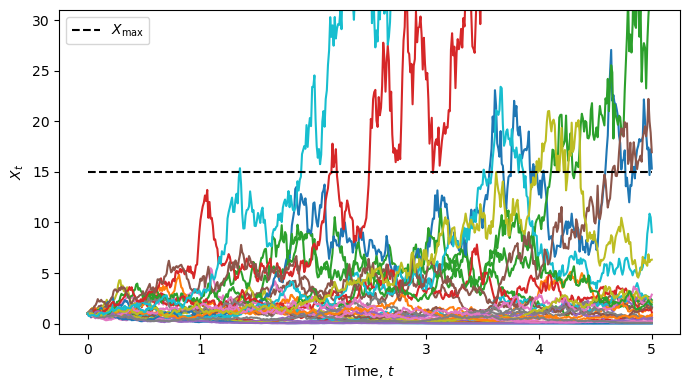

In [11]:
a_ = 0.5
b_ = 1
X0_ = 1
Xmax = 15

def a(X, t):
    return a_ * X

def b(X, t):
    return b_ * X

# Several initial values leads to several solutions
Np = 30
X0 = X0_*np.ones(Np)
# Integration time
tmax = 5
# timestep
dt = 0.01

X = solve_SDE(X0, tmax, dt, a, b, EM)

t = dt*np.arange(len(X))

# Plot the solution
fig = plt.figure(figsize = (7, 4))
plt.plot(t, X)
plt.plot(t, Xmax*np.ones_like(t), '--', c='k', label='$X_\mathrm{max}$')
plt.xlabel('Time, $t$')
plt.ylabel('$X_t$')
plt.legend()
plt.ylim(-1, 31)
plt.tight_layout()

## Find distribution of first-passage times of $X \geq X_{\mathrm{max}}$


Here, we use a simple implementation that runs the regular solver, and then afterwards finds the time where each trajectory first crossed $X_\mathrm{max}$. This is simple to implement, but not very efficient in terms of time and memory.

Euler-Maruyama:    2 out of 100000 trajectories did not cross Xmax
Milstein:          2 out of 100000 trajectories did not cross Xmax


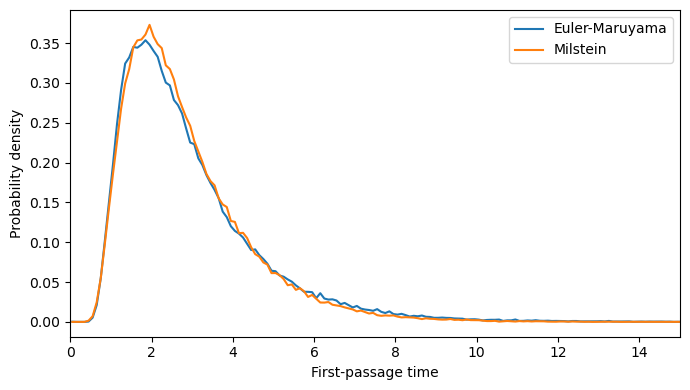

In [19]:
a_ = 1.5
b_ = 1
X0_ = 1
Xmax = 15


def a(X, t):
    return a_ * X

def b(X, t):
    return b_ * X

# Several initial values leads to several solutions
Np = 100000
X0 = X0_ * np.ones(Np)
# Integration time
Tmax = 30 # Long enough to make sure that most solutions have passed Xmax (for these values of a, b, and X0)
# timestep
dt = 0.05

X_EM = solve_SDE(X0, Tmax, dt, a, b, EM)
X_M1 = solve_SDE(X0, Tmax, dt, a, b, milstein_finite_diff)

t = np.linspace(0, Tmax, X_EM.shape[0])

# Find time of first passage
it_EM = np.argmax(X_EM >= Xmax, axis=0)
it_M1 = np.argmax(X_M1 >= Xmax, axis=0)

# Count how many trajectories did not reach Xmax
count_EM = np.sum(np.amax(X_EM, axis=0) < Xmax)
count_M1 = np.sum(np.amax(X_M1, axis=0) < Xmax)
print(f'Euler-Maruyama: {count_EM:>4} out of {Np} trajectories did not cross Xmax')
print(f'Milstein:       {count_EM:>4} out of {Np} trajectories did not cross Xmax')

fig = plt.figure(figsize=(7, 4))

# Histogram bins and their midpoints
bins = np.linspace(0, 30, 301)
mids = bins[:-1] + (bins[1]-bins[0])/2

# Find and plot histograms
h, _ = np.histogram(t[it_EM], bins=bins, density=True)
plt.plot(mids, h, label='Euler-Maruyama')

h, _ = np.histogram(t[it_M1], bins=bins, density=True)
plt.plot(mids, h, label='Milstein')

plt.xlabel('First-passage time')
plt.ylabel('Probability density')
plt.legend()
plt.xlim(0, 15)
plt.tight_layout()

Estimated memory use: 8.941 GB


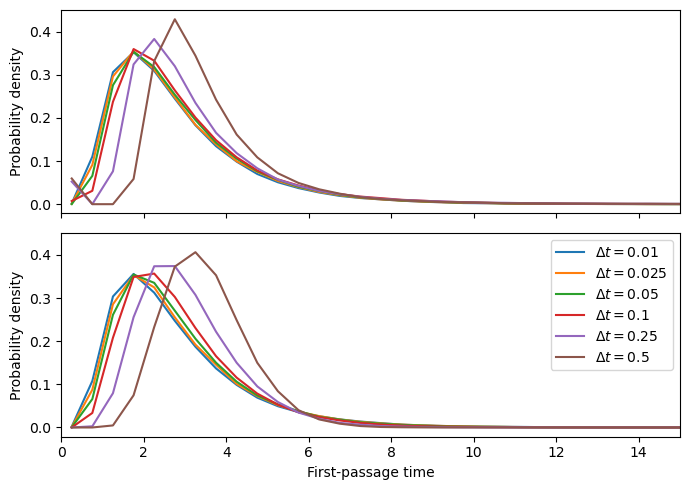

In [31]:
a_ = 1.5
b_ = 1
X0_ = 1
Xmax = 15


def a(X, t):
    return a_ * X

def b(X, t):
    return b_ * X

# Several initial values leads to several solutions
Np = 50000
X0 = X0_ * np.ones(Np)
# Integration time
Tmax = 30

fig, ax = plt.subplots(nrows=2, figsize=(7, 5), sharex=True, sharey=True)


timesteps = np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])
mean_EM = np.zeros_like(timesteps)
mean_M1 = np.zeros_like(timesteps)

for i, dt in enumerate(timesteps):
    X_EM = solve_SDE(X0, Tmax, dt, a, b, EM)
    X_M1 = solve_SDE(X0, Tmax, dt, a, b, milstein_finite_diff)

    t = np.linspace(0, Tmax, X_EM.shape[0])

    # Find time of first passage
    it_EM = np.argmax(X_EM >= Xmax, axis=0)
    it_M1 = np.argmax(X_M1 >= Xmax, axis=0)

    # Histogram bins and their midpoints
    bins = np.linspace(0, 30, 61)
    mids = bins[:-1] + (bins[1]-bins[0])/2

    # Find and plot histograms
    h, _ = np.histogram(t[it_EM], bins=bins, density=True)
    ax[0].plot(mids, h, label=f'$\Delta t = {dt}$')

    h, _ = np.histogram(t[it_M1], bins=bins, density=True)
    ax[1].plot(mids, h, label=f'$\Delta t = {dt}$')
    
    # Store mean
    mean_EM[i] = np.mean(t[it_EM])
    mean_M1[i] = np.mean(t[it_M1])

ax[1].set_xlabel('First-passage time')
ax[0].set_ylabel('Probability density')
ax[1].set_ylabel('Probability density')
ax[1].legend()
plt.xlim(0, 15)
plt.tight_layout()

## A dedicated function for finding stopping times

Below, we implement a dedicated function for stopping times. It uses a normal solver for each time step, but instead of solving for the entire time interval, it only keeps track of the current value of $X$, and it checks after every timestep if $X$ has crossed $X_\mathrm{max}$. It then discards all those solutions, and only continues with those that have not yet crossed $X_\mathrm{max}$. This is far more efficient both in terms of memory, since it does not have to store the entire trajectory, and in time, since it does not have to keep doing computations for those trajectories that have already crossed.

In [35]:
def stopping_times(X0, Xmax, tmax, dt, a, b, solver):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    Nt = int(tmax/dt) + 1
    # If X0 is not an array, turn it into a 1-element array
    if not isinstance(X0, np.ndarray):
        X0 = np.array([X0])
    # Arrays to track solution
    X = X0.copy() # Copy to avoid overwriting input
    t = 0
    
    times = []
    for n in range(1, Nt):
        # Find all X that have crossed Xmax, and make note of time
        mask = X >= Xmax
        times += np.sum(mask) * [t]
        # Discard solutions that have crossed Xmax
        X = X[~mask]
        # Call solver
        X = solver(X, t, dt, a, b)
        # Increment time
        t += dt
    return np.array(times)

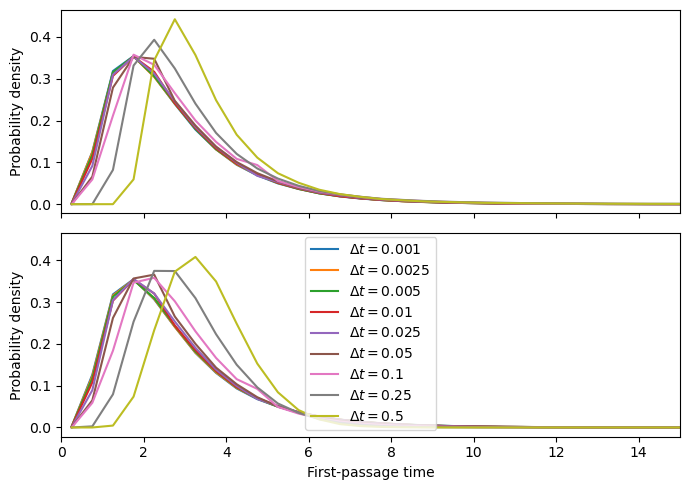

In [37]:
a_ = 1.5
b_ = 1
X0_ = 1
Xmax = 15


def a(X, t):
    return a_ * X

def b(X, t):
    return b_ * X

# Several initial values leads to several solutions
Np = 500000
X0 = X0_ * np.ones(Np)
# Integration time
Tmax = 30

fig, ax = plt.subplots(nrows=2, figsize=(7, 5), sharex=True, sharey=True)


timesteps = np.array([0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5])
mean_EM = np.zeros_like(timesteps)
mean_M1 = np.zeros_like(timesteps)

for i, dt in enumerate(timesteps):
    times_EM = stopping_times(X0, Xmax, Tmax, dt, a, b, EM)
    times_M1 = stopping_times(X0, Xmax, Tmax, dt, a, b, milstein_finite_diff)

    # Histogram bins and their midpoints
    bins = np.linspace(0, 30, 61)
    mids = bins[:-1] + (bins[1]-bins[0])/2

    # Find and plot histograms
    h, _ = np.histogram(times_EM, bins=bins, density=True)
    ax[0].plot(mids, h, label=f'$\Delta t = {dt}$')

    h, _ = np.histogram(times_M1, bins=bins, density=True)
    ax[1].plot(mids, h, label=f'$\Delta t = {dt}$')
    
    # Store mean
    mean_EM[i] = np.mean(times_EM)
    mean_M1[i] = np.mean(times_M1)

ax[1].set_xlabel('First-passage time')
ax[0].set_ylabel('Probability density')
ax[1].set_ylabel('Probability density')
ax[1].legend()
plt.xlim(0, 15)
plt.tight_layout()

## Convergence of the mean stopping time

Below we plot the convergence of the mean stopping time, using the shortest timestep with the Milstein solver as the reference solution against which the error is calculated.

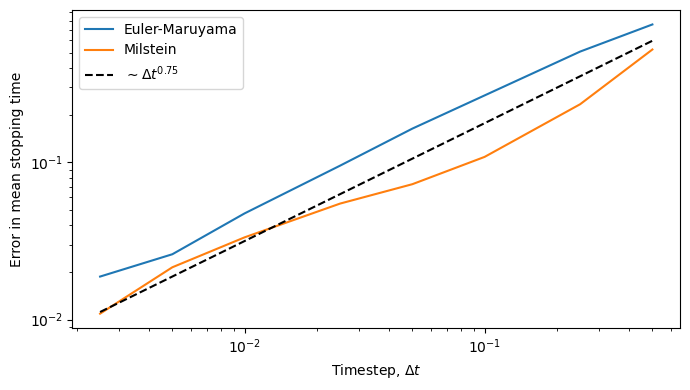

In [42]:
fig = plt.figure(figsize=(7,4))
plt.plot(timesteps[1:], mean_EM[1:] - mean_M1[0], label='Euler-Maruyama')
plt.plot(timesteps[1:], mean_M1[1:] - mean_M1[0], label='Milstein')
plt.plot(timesteps[1:], timesteps[1:]**0.75, '--', c='k', label='$\sim \Delta t^{0.75}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Timestep, $\Delta t$')
plt.ylabel('Error in mean stopping time')
plt.legend()
plt.tight_layout()

## Duffing-van der Pol oscillator

Solve the (2-component) SDE given by

\begin{align}
\mathrm{d}X &= V\, \mathrm{d}t \\
\mathrm{d}V &= \big(X(\alpha-X^2) - V^2\big) \mathrm{d}t + \sigma X \, \mathrm{d}W_t
\end{align}

with parameters $\alpha=1.0$, $\sigma=0.2$. Solve for different initial conditions, letting $X_0$ be evenly spaced out between $-4$ and $-2$, with $V=0$ in all cases.

In [173]:
def a(X, t):
    # Here, X has shape (2, Np)
    # with X[0,:] being X in the equations above,
    # and X[1,:] being V in the equations above.
    alpha = 1.0
    dX = np.zeros_like(X)
    dX[0,:] = X[1,:]
    dX[1,:] = X[0,:]*(alpha - X[0,:]**2) - X[1,:]
    return dX

def b(X, t):
    # Here, X has shape (2, Np)
    # with X[0,:] being X in the equations above,
    # and X[1,:] being V in the equations above.
    sigma = 0.2
    dX = np.zeros_like(X)
    dX[1,:] = sigma*X[0,:]
    return dX


# Several initial values leads to several solutions
Np = 10
X0 = np.zeros((2, Np))
X0[0,:] = np.linspace(-4, -2, Np)
# Integration time
Tmax = 10
# timestep
dt = 0.001

# Pre-generate Np identical realisations of a Wiener process
Nt = int(Tmax/dt) + 1
t = np.linspace(0, Tmax, Nt)
#W = np.zeros((Nt, Np))
#W[1:,:] = np.cumsum(np.random.normal(loc=0, scale=np.sqrt(dt), size=Nt-1))[:,None]

X_EM = solve_SDE(X0, Tmax, dt, a, b, EM)

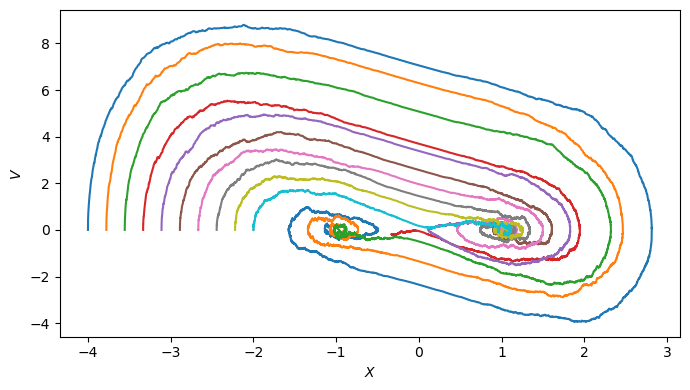

In [175]:
fig = plt.figure(figsize=(7,4))
for i in range(X_EM.shape[-1]):
    plt.plot(X_EM[:,0,i], X_EM[:,1,i])
    
plt.xlabel('$X$')
plt.ylabel('$V$')
plt.tight_layout()
plt.savefig('exercise3_duffing_vdp.pdf')

In [180]:
def a(X, t):
    # Here, X has shape (2, Np)
    # with X[0,:] being X in the equations above,
    # and X[1,:] being V in the equations above.
    alpha = 1.0
    dX = np.zeros_like(X)
    dX[0,:] = X[1,:]
    dX[1,:] = X[0,:]*(alpha - X[0,:]**2) - X[1,:]
    return dX

def b(X, t):
    # Here, X has shape (2, Np)
    # with X[0,:] being X in the equations above,
    # and X[1,:] being V in the equations above.
    sigma = 0.5
    dX = np.zeros_like(X)
    dX[1,:] = sigma*X[0,:]
    return dX


# Several initial values leads to several solutions
Np = 100
X0 = np.zeros((2, Np))
X0[0,:] = np.linspace(-4, -2, Np)
# Integration time
Tmax = 20
# timestep
dt = 0.05

# Pre-generate Np identical realisations of a Wiener process
Nt = int(Tmax/dt) + 1
t = np.linspace(0, Tmax, Nt)
W = np.zeros((Nt, Np))
W[1:,:] = np.cumsum(np.random.normal(loc=0, scale=np.sqrt(dt), size=Nt-1))[:,None]

X_EM = solve_SDE(X0, Tmax, dt, a, b, EM, W=W)
X_M1 = solve_SDE(X0, Tmax, dt, a, b, milstein_finite_diff, W=W)

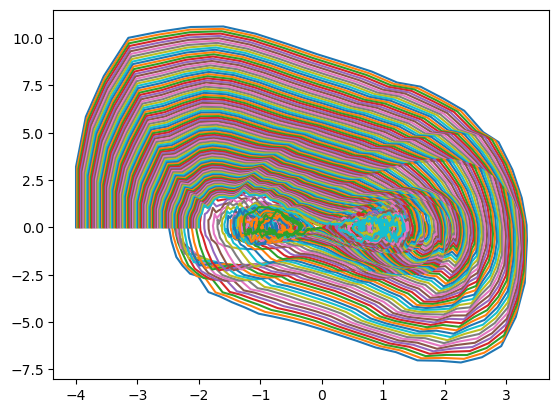

In [181]:
for i in range(X_EM.shape[-1]):
    plt.plot(X_EM[:,0,i], X_EM[:,1,i])

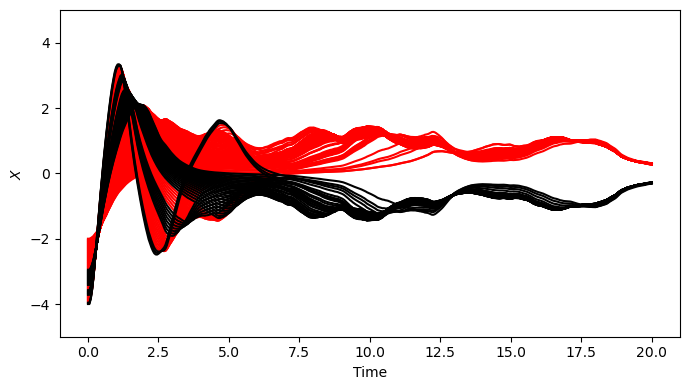

In [182]:
fig = plt.figure(figsize=(7,4))

# Colour differently by end position
mask = X_EM[-1,0,:] > 0
plt.plot(t, X_EM[:,0,mask], c='r')
plt.plot(t, X_EM[:,0,~mask], c='k')
plt.xlabel('Time')
plt.ylabel('$X$')
plt.ylim(-5, 5)
plt.tight_layout()

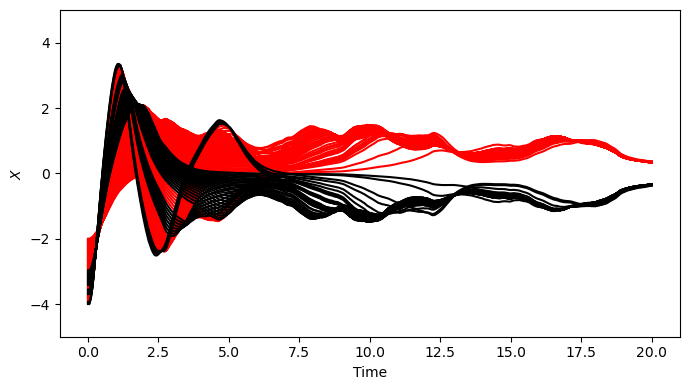

In [183]:
fig = plt.figure(figsize=(7,4))

# Colour differently by end position
mask = X_M1[-1,0,:] > 0
plt.plot(t, X_M1[:,0,mask], c='r')
plt.plot(t, X_M1[:,0,~mask], c='k')
plt.xlabel('Time')
plt.ylabel('$X$')
plt.ylim(-5, 5)
plt.tight_layout()

# References

Maruyama, G., Continuous Markov processes and stochastic equations. _Rend. Circ. Mat. Palermo_ 4, 48–90 (1955). https://doi.org/10.1007/BF02846028